## Estimating richness using breakaway
## This generates Supplemental Figure 1

In [17]:
# Loading required packages
library(plyr)
library(dplyr)
library(reshape)
library(ggplot2)
library(phyloseq)
library(breakaway)
library(wesanderson)

In [18]:
ps = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")

In [19]:
FreqTableGenerator = function(Sample){
    df = data.frame(t(otu_table(ps))[,Sample])
    # Grab the OTU table
    colnames(df)="Frequency"
    # Add a column for the frequencies of the OTUs
    df = df %>%
        group_by(Frequency)%>%
        summarize(nOTUs=n())%>%
        arrange(Frequency)
    # Summarize the total OTUs that are present at each frequency
    df = df[df$Frequency>1,]
    # Cut out the 0 and 1 frequencies (because dada2 trimmed singletons)
    colnames(df)=NULL
    # Omit column names
    df = as.matrix(df)
    # Spit out a nice matrix
    df
}
# Generates the frequency table summary needed by breakaway

In [20]:
Samples = sample_names(ps)

In [21]:
report = data.frame(name="",Richness_estimate="",Richness_stderr="",Richness_model="")
breakawayrunner = function(SampleName){
    df = FreqTableGenerator(SampleName)
    if(df[1,1]==2 & (sum(df[1:6,1])==sum(c(2:7)))){
        # First, check that the first frequency count is, indeed, 2,
        # and there are at least 6 consecutive counts (could actually just do this test)
            m = breakaway_nof1(df, answers=TRUE, plot=FALSE, print=FALSE)
        # Run breakaway for the no singletons data
            Richness_model = m$name
            Richness_estimate = m$est
            Richness_stderr = m$seest
            name = SampleName
        # Grab the outputs
            report = data.frame(name,Richness_estimate,Richness_stderr,Richness_model)
        # Generate a report
    } else {
        name = SampleName
        report=data.frame(name)
        # If breakaway isn't going to work anyway, just spit out the name (and NAs)
        }

    report

}

In [22]:
# Running Breakaway
Reports = mdply(Samples,breakawayrunner)
head(Reports)

X1,name,Richness_estimate,Richness_stderr,Richness_model
1,15S-NT-19O,505.4377,30.42776,WLRM
2,15S-NT-20O,367.1483,1139.13057,model_1_1
3,15S-NT-21M,315.9218,110.29103,model_1_1
4,15S-NT-21O,1706.3637,55012.99048,model_2_1
5,15S-NT-22M,344.9411,21.71090,WLRM
6,15S-NT-22O,818.8278,4476.50293,model_2_1


In [23]:
Report_Summary = Reports %>%
    group_by(Richness_model)%>%
    summarize(n())
Report_Summary

Richness_model,n()
WLRM,23
model_1_1,66
model_2_1,11
model_3_2,1


In [24]:
# Add richness estimates and standard error to the sample dataframe
sample_data(ps)[,colnames(Reports)[3:5]]=Reports[,3:5]

In [25]:
# Grabbing the sample data
d = sample_data(ps)

In [26]:
# Setting up function to propagate errors from richness estimates
BettaRunner = function(Veg_Comm){
    d = d[d$Veg_Comm==Veg_Comm,]
    CoVars = data.frame(Veg_Comm=d$Veg_Comm,Severity_Class=d$Severity_Class)
    CoVars$Severity=c(rep("",dim(CoVars)[1]))
    SeverityOptions = levels(CoVars$Severity_Class)
    N = length(SeverityOptions)
    for (i in 1:dim(CoVars)[1]){
        Severity_Class = paste(CoVars$Severity_Class[i])    
        if("Unburned" %in% SeverityOptions){CoVars$Unburned[i] = ifelse(Severity_Class=="Unburned",1,0)}
        if("Low" %in% SeverityOptions){CoVars$Low[i] = ifelse(Severity_Class=="Low",1,0)}
        if("Moderate" %in% SeverityOptions){CoVars$Moderate[i] = ifelse(Severity_Class=="Moderate",1,0)}
        if("High" %in% SeverityOptions){CoVars$High[i] = ifelse(Severity_Class=="High",1,0)}
    }
    nmax = 3+N
    CoVars = as.matrix(CoVars[,4:nmax])
    Richness_estimates = as.vector(d$Richness_estimate)
    Richness_stderr = as.vector(d$Richness_stderr)
    BettaEst = betta(Richness_estimates,Richness_stderr,CoVars)
    X = data.frame(BettaEst$table)
    X$Veg_Comm = Veg_Comm
    return(X)
}

In [27]:
# Which vegetation communities we will apply the function to (all of them)
Veg_Comms = levels(d$Veg_Comm)

In [28]:
# Run the function on all veg comms
x = lapply(Veg_Comms,FUN=BettaRunner)

In [29]:
x[[1]]$Severity_Class=row.names(x[[1]])
x[[2]]$Severity_Class=row.names(x[[2]])
x[[3]]$Severity_Class=row.names(x[[3]])
x[[4]]$Severity_Class=row.names(x[[4]])
x[[5]]$Severity_Class=row.names(x[[5]])

In [30]:
# Join into dataframe and adjust errors
x = rbind(x[[1]],x[[2]],x[[3]],x[[4]],x[[5]])
x = data.frame(x)
x$p.adj = p.adjust(x$p.values, method = "bonferroni")
x$Ymin = x$Estimates-1.96*x$Standard.Errors
x$Ymax = x$Estimates+1.96*x$Standard.Errors
x$comb = paste(x$Veg_Comm,x$Severity_Class)
x

,Estimates,Standard.Errors,p.values,Veg_Comm,Severity_Class,p.adj,Ymin,Ymax,comb
Unburned,403.2771,219.51588,0.066,Black Spruce,Unburned,1.000,-26.97398,833.5283,Black Spruce Unburned
Moderate,517.9439,158.21462,0.001,Black Spruce,Moderate,0.016,207.84324,828.0446,Black Spruce Moderate
Unburned1,443.6937,96.29126,0.000,Jack Pine,Unburned,0.000,254.96280,632.4245,Jack Pine Unburned
Low,434.9206,108.78287,0.000,Jack Pine,Low,0.000,221.70616,648.1350,Jack Pine Low
Moderate1,286.2213,57.23543,0.000,Jack Pine,Moderate,0.000,174.03988,398.4028,Jack Pine Moderate
High,236.3571,33.58243,0.000,Jack Pine,High,0.000,170.53553,302.1787,Jack Pine High
Unburned2,410.1505,43.60432,0.000,Mixedwood,Unburned,0.000,324.68605,495.6150,Mixedwood Unburned
Low1,422.6467,39.93388,0.000,Mixedwood,Low,0.000,344.37631,500.9171,Mixedwood Low
Moderate2,401.3868,33.36321,0.000,Mixedwood,Moderate,0.000,335.99488,466.7787,Mixedwood Moderate
High1,223.2758,52.10218,0.000,Mixedwood,High,0.000,121.15551,325.3961,Mixedwood High


In [31]:
# Setting factors
x$Severity_Class=factor(x$Severity_Class,levels=c("Unburned","Low","Moderate","High"))
x$Veg_Comm = factor(x$Veg_Comm, levels=c("Black Spruce", "Jack Pine", "Mixedwood", "Treed Wetland", "Open Wetland"))

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

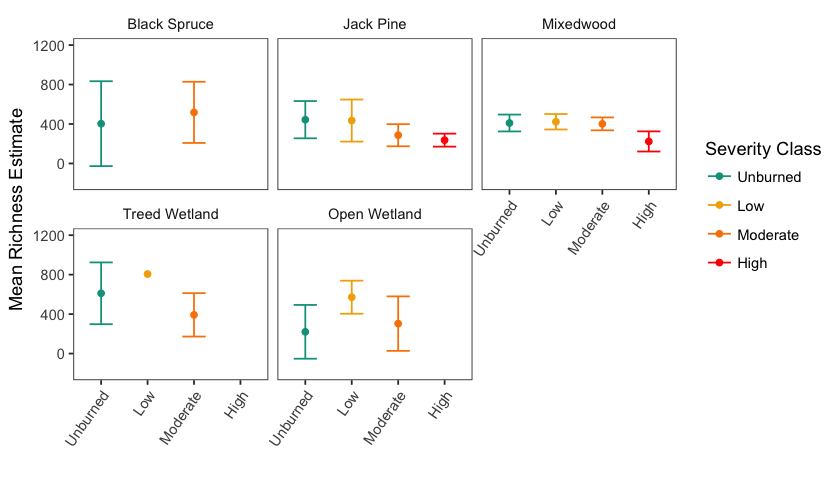

In [32]:
# Plotting the data

options(repr.plot.width=7, repr.plot.height=4)
p = ggplot(x)
p = p + geom_errorbar(aes(x=Severity_Class,min = Ymax, max = Ymin,color=Severity_Class),width=0.5)
p = p + geom_point(aes(x=Severity_Class,y=Estimates,color=Severity_Class))
p = p + facet_wrap(~Veg_Comm)
palette = wes_palette("Darjeeling")[c(2,3,4,1,5)]
p = p + scale_colour_manual(values=palette)
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
   ,strip.background = element_rect(colour="white", fill="white"))
p = p + theme(axis.text.x = element_text(angle=55,hjust=1))
p = p + ylab("Mean Richness Estimate")
p = p + xlab("")
p = p + guides(colour=guide_legend(title="Severity Class"))
p = p + ylim(-200,1200)
p